In [0]:
# Import libs

import pandas as pd
import re
import numpy as np
from nltk.tokenize import WordPunctTokenizer, TweetTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [0]:
# Load Training, Dev and Test Data

def loadData(filepath):
  data = pd.read_csv(filepath)
  # Currently working on region level predictor
  data.drop(['lat','long','state'],axis=1,inplace=True)
  # Filter and remove anomaly data
  data = data[data.region != 'MX']  # Remove 'Mexico' records - Due to Reverse geocoding
  data = data[data.region != 'CA']  # Remove 'Canada' records - Due to Reverse geocoding
  data.dropna(inplace=True)
  data.reset_index(drop=True,inplace=True)
  return data

# train file and dev file has columns tweet, lat, long, state, region
# test file has columns uid (userid), tweet, lat, long, state, region
train = loadData("Path to train .csv file")
dev = loadData("Path to dev .csv file")
test = loadData("Path to test .csv file")
tweet_test = test.drop('uid', axis=1)  # Tweet level test
user_test = test.drop('tweet', axis=1).drop_duplicates()  # User level test

# print(train.head(5))
# print(train.iloc[0])
# dev.region.unique()
# train.info()
print("Train shape: "+ str(train.shape))
print("Dev shape: "+ str(dev.shape))
print("Test shape: "+ str(test.shape))
print("Tweet Test shape: "+ str(tweet_test.shape))
print("User Test shape: "+ str(user_test.shape))

Train shape: (218147, 2)
Dev shape: (74079, 2)
Test shape: (74382, 3)
Tweet Test shape: (74382, 2)
User Test shape: (1858, 2)


In [0]:
# Data Preparation

# Tweet cleaning
tt = TweetTokenizer(strip_handles=True, reduce_len=True)
pat1 = r'@[A-Za-z0-9_]+'  # To remove '@' mentions
pat2 = r'https?://[^ ]+'  # To remove web links starting with http
combined_pat = r'|'.join((pat1, pat2))
www_pat = r'www.[^ ]+'  # To remove web links starting without http
'''negations_dic = {"isn't":"is not", "aren't":"are not", "wasn't":"was not", "weren't":"were not",
                "haven't":"have not","hasn't":"has not","hadn't":"had not","won't":"will not",
                "wouldn't":"would not", "don't":"do not", "doesn't":"does not","didn't":"did not",
                "can't":"can not","couldn't":"could not","shouldn't":"should not","mightn't":"might not",
                "mustn't":"must not"}
neg_pattern = re.compile(r'\b(' + '|'.join(negations_dic.keys()) + r')\b')'''

def tweet_cleaner(text):
    stripped = re.sub(combined_pat, '', text)
    stripped = re.sub(www_pat, '', stripped)
    lower_case = stripped.lower()
    # neg_handled = neg_pattern.sub(lambda x: negations_dic[x.group()], lower_case)
    # letters_only = re.sub("[^a-zA-Z]", " ", neg_handled)
    # During the letters_only process two lines above, it has created unnecessay white spaces,
    # Will tokenize and join together to remove unneccessary white spaces
    # words = [x for x  in wpt.tokenize(letters_only) if len(x) > 1]
    words = [x for x  in tt.tokenize(lower_case) if len(x) > 1]
    return (" ".join(words)).strip()
  
# print(tweet_cleaner(" www.msundarv.com don't First batting also dhik dhik, chasing also dhik dhik! Finger nails, toe nails, no bias! 😷 #Yellove #WhistlePodu #CSKvRR 🦁💛"))

train.tweet = train.tweet.apply(tweet_cleaner)
# print(train.head(5))
# print(train.iloc[0])
dev.tweet = dev.tweet.apply(tweet_cleaner)
tweet_test.tweet = tweet_test.tweet.apply(tweet_cleaner)

print("Train shape: "+ str(train.shape))
print("Dev shape: "+ str(dev.shape))
print("Test shape: "+ str(tweet_test.shape))

Train shape: (218147, 2)
Dev shape: (74079, 2)
Test shape: (74382, 2)


In [0]:
# Vectorization

from keras.utils import to_categorical

tweet_vectorizer = TfidfVectorizer(max_features = 5000,ngram_range = (1,3),stop_words='english')

X_train = tweet_vectorizer.fit_transform(train.tweet)
X_dev = tweet_vectorizer.transform(dev.tweet)
X_test = tweet_vectorizer.transform(tweet_test.tweet)

print("X_Train Shape: "+str(X_train.shape))
print("X_Dev Shape: "+str(X_dev.shape))
print("X_Test Shape: "+str(X_test.shape))

y_train = to_categorical(train.region.replace({ 'midwest': 0, 'northeast': 1, 'south': 2, 'west' : 3 }), num_classes=None)
y_dev = to_categorical(dev.region.replace({ 'midwest': 0, 'northeast': 1, 'south': 2, 'west' : 3 }), num_classes=None)
y_test = to_categorical(tweet_test.region.replace({ 'midwest': 0, 'northeast': 1, 'south': 2, 'west' : 3 }), num_classes=None)

Using TensorFlow backend.


X_Train Shape: (218147, 5000)
X_Dev Shape: (74079, 5000)
X_Test Shape: (74382, 5000)


In [0]:
# Define MLP

from keras.models import Sequential
from keras import layers

input_dim = X_train.shape[1]  # Number of input features

def create_model(no_of_units, noise, optim):
  model = Sequential()
  model.add(layers.Dense(no_of_units, input_shape=(input_dim,), activation='relu'))
  model.add(layers.GaussianNoise(noise))
  model.add(layers.Dense(int(no_of_units/2), activation='relu'))
  model.add(layers.GaussianNoise(0.9*noise))
  model.add(layers.Dense(int(no_of_units/4), activation='relu'))
  model.add(layers.GaussianNoise(0.9*noise))
  model.add(layers.Dense(4, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer=optim, metrics=['accuracy'])
  model.summary()
  return model

In [0]:
# Hyperparameters Optimization

from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV

param_grid = dict(no_of_units=[16, 32, 64], noise = [0.2, 0], optim = ['sgd', 'adam', 'rmsprop', 'adagrad', 'adadelta'])

model = KerasClassifier(build_fn=create_model, epochs=20, batch_size=10000, verbose=0)
grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid, cv=3, verbose=1, n_iter=7, n_jobs = -1)
grid_result = grid.fit(X_train, y_train)

print("Best Grid Score:  {:.2f}".format(grid_result.best_score_*100))
print("Best Grid params: "+ str(grid_result.best_params_))

mlp_grid_accuracy = grid.score(X_test, y_test)
print("MLP Grid Test Accuracy:  {:.2f}".format(mlp_grid_accuracy*100))

# Best params - no_of_units = [32, 16], noise = [0.2]

In [0]:
# Train and predict using MLP

from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping

model = create_model(32, 0.2, 'adam')

# Save the checkpoint
ckptfilepath = "Path to .hdf5 checkpopint file"
# Keep only a single checkpoint, the best over test accuracy.
checkpoint = ModelCheckpoint(ckptfilepath,
                            monitor='val_acc',
                            verbose=1,
                            save_best_only=True,
                            mode='max')
early_stopping_monitor = EarlyStopping(patience=10)

history = model.fit(X_train, y_train, epochs=100, validation_data=(X_dev, y_dev), batch_size=10000, callbacks=[checkpoint, early_stopping_monitor])

mlp_loss, mlp_accuracy = model.evaluate(X_test, y_test, verbose=False)
print("MLP Test Accuracy:  {:.2f}".format(mlp_accuracy*100))

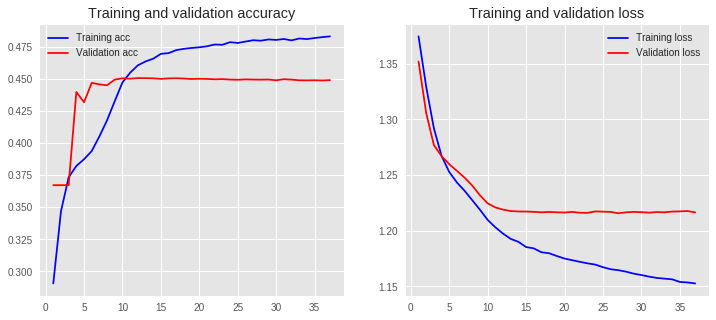

In [0]:
# Plot training loss values and metric values 

import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    
plot_history(history)

In [0]:
# Evaluate best fit MLP

from sklearn.metrics import accuracy_score

bestmodelfilepath = "Path to best model .hdf5 file"

model = create_model(32, 0.2, 'adam')
model.load_weights(bestmodelfilepath)

mlp_loss, mlp_accuracy = model.evaluate(X_test, y_test, verbose=False)
print("MLP Best Tweet level Test Accuracy:  {:.2f}".format(mlp_accuracy*100))


# Predict tweet level regions using trained model
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
# print(y_pred.shape)

# Predict user level region
test['ypred'] = y_pred
user_pred = test.drop(['tweet','region'],axis=1)
pred = user_pred.groupby(['uid'])['ypred'].agg(lambda x:x.value_counts().index[0])
# print(pred.head(10))

# Compare with true values
true = user_test.sort_values(by=['uid']).replace({ 'midwest': 0, 'northeast': 1, 'south': 2, 'west' : 3 })
# print(true.head(10))

final_acc = accuracy_score(true['region'], pred)
print("MLP Final Accuracy:  {:.2f}".format(final_acc*100))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 32)                160032    
_________________________________________________________________
gaussian_noise_7 (GaussianNo (None, 32)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 16)                528       
_________________________________________________________________
gaussian_noise_8 (GaussianNo (None, 16)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 8)                 136       
_________________________________________________________________
gaussian_noise_9 (GaussianNo (None, 8)                 0         
_________________________________________________________________
dense_12 (Dense)             (None, 4)                 36        
Total para



---

